In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.utils.multiclass import unique_labels
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments,
    EarlyStoppingCallback
)
from datasets import Dataset
import torch
import numpy as np
import os

# Load dataset
df = pd.read_csv('5c_emotion.csv')
df = df.dropna()
data = df.sample(frac=1, random_state=42).reset_index(drop=True)
print(data.head())
X = data['text']
y = data['label']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y.astype(str))

# Create Hugging Face dataset
dataset = Dataset.from_pandas(pd.DataFrame({'text': X, 'label': y_encoded}))
dataset = dataset.train_test_split(test_size=0.2, seed=42)

# Load BanglaBERT tokenizer and model
device = torch.device("cuda")
model_name = 'xlm-roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, 
    num_labels=len(label_encoder.classes_)

).to(device)

# Tokenize
def tokenize_function(example):
    return tokenizer(example['text'], padding='max_length', truncation=True, max_length=128)

dataset = dataset.map(tokenize_function, batched=True)
dataset = dataset.remove_columns(['text']).rename_column('label', 'labels')
dataset.set_format('torch')

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    # evaluation_strategy='epoch',
    # save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=20,
    # load_best_model_at_end=True,
    metric_for_best_model='f1',
    greater_is_better=True,
    warmup_ratio=0.1,
    gradient_accumulation_steps=2,
    report_to=[]
)

# Metrics
def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    labels = eval_pred.label_ids
    return {
        "accuracy": accuracy_score(labels, predictions),
        "f1": f1_score(labels, predictions, average='weighted')
    }

# Trainer with early stopping
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
    # callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# Train
trainer.train()



c:\Users\USERAS\anaconda3\envs\resPy\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


            text    label
0  খুবই মজার ছিল    happy
1    এটা ঠিক আছে  neutral
2   খুবই আনন্দিত    happy
3  খুবই মজার ছিল    happy
4  তুমি খুব মজার    happy


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Parameter 'function'=<function tokenize_function at 0x000002CD956E0820> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.
100%|██████████| 25/25 [00:01<00:00, 17.20ba/s]
C:\Users\USERAS\AppData\Local\Temp\ipykernel_816

Step,Training Loss
20,1.631000
40,1.614600
60,1.622200
80,1.609800
100,1.631700
120,1.616200
140,1.608100
160,1.609400
180,1.589000
200,1.607400


c:\Users\USERAS\anaconda3\envs\resPy\lib\site-packages\transformers\utils\generic.py:271: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = np.array(obj)
c:\Users\USERAS\anaconda3\envs\resPy\lib\site-packages\transformers\utils\generic.py:271: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.array(obj)
c:\Users\USERAS\anaconda3\envs\resPy\lib\site-packages\t

RuntimeError: [enforce fail at inline_container.cc:659] . unexpected pos 52352 vs 52244

 Classification Report:
               precision    recall  f1-score   support

       happy       1.00      1.00      1.00      7934
         joy       0.87      0.90      0.89      2683
     neutral       1.00      0.98      0.99      4031
         sad       0.95      0.94      0.95      4978
       toxic       0.93      0.93      0.93      4922

    accuracy                           0.96     24548
   macro avg       0.95      0.95      0.95     24548
weighted avg       0.96      0.96      0.96     24548



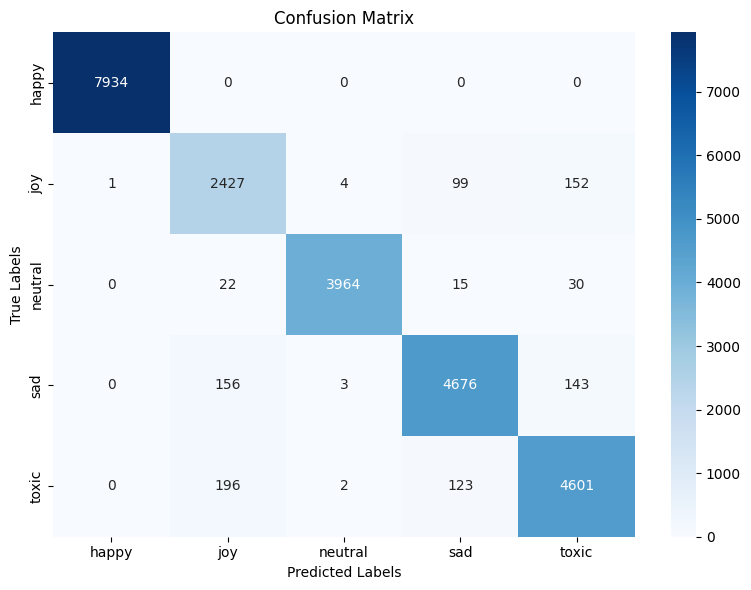

In [ ]:

# Evaluate
eval_results = trainer.evaluate()
print(f"\n Evaluation results: {eval_results}")

# Predictions
predictions_output = trainer.predict(dataset['test'])
predictions = np.argmax(predictions_output.predictions, axis=1)
labels = predictions_output.label_ids
# Classification report
used_labels = sorted(unique_labels(labels, predictions))
used_class_names = [str(label_encoder.classes_[i]) for i in used_labels]

report = classification_report(
    labels, predictions,
    labels=used_labels,
    target_names=used_class_names,
    zero_division=0
)
print(" Classification Report:\n", report)

# Confusion matrix
conf_matrix = confusion_matrix(labels, predictions, labels=used_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=used_class_names, yticklabels=used_class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()


In [ ]:
trainer.save_model('./roberta-ff')

tokenizer.save_pretrained('./roberta-t-ff')
